In [6]:
import random
import numpy as np
import time
import matplotlib.pyplot as plt
from collections import defaultdict
from typing import List, Dict, Tuple


In [7]:
# Dummy models to simulate the database structure
class Teacher:
    def __init__(self, id, subject_id):
        self.id = id
        self.subject_id = subject_id

class Section:
    def __init__(self, id, grade_level=None):
        self.id = id
        self.grade_level = grade_level

class Subject:
    def __init__(self, id):
        self.id = id

class Schedule:
    def __init__(self, day, time_slot, teacher_id, section_id, subject_id):
        self.day = day
        self.time_slot = time_slot
        self.teacher_id = teacher_id
        self.section_id = section_id
        self.subject_id = subject_id


In [8]:
class MOGAScheduler:
    def __init__(self, teachers: List[Teacher], sections: List[Section], subjects: List[Subject]):
        self.teachers = teachers
        self.sections = sections
        self.subjects = subjects
        
        self.POPULATION_SIZE = 50
        self.GENERATIONS = 50
        self.INITIAL_MUTATION_RATE = 0.2
        self.MIN_MUTATION_RATE = 0.05
        self.CROSSOVER_RATE = 0.9
        self.ELITISM_COUNT = 5
        self.EARLY_STOP_GENERATIONS = 10

        self.time_slots = ["7:30-8:30", "8:30-9:30", "9:30-10:30", "10:30-11:30", 
                           "1:00-2:00", "2:00-3:00", "3:00-4:00", "4:00-5:00"]
        self.days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
        self.teacher_subjects = self._map_teacher_subjects()
        
        self.fitness_history = []

    def _map_teacher_subjects(self):
        teacher_subjects = defaultdict(list)
        for teacher in self.teachers:
            teacher_subjects[teacher.id].append(teacher.subject_id)
        return teacher_subjects

    def _create_random_schedule(self):
        chromosome = []
        for section in self.sections:
            for subject in self.subjects:
                suitable_teachers = [t.id for t in self.teachers if subject.id in self.teacher_subjects[t.id]]
                if not suitable_teachers:
                    suitable_teachers = [t.id for t in self.teachers]
                chromosome.append({
                    'day': random.choice(self.days),
                    'time_slot': random.choice(self.time_slots),
                    'teacher_id': random.choice(suitable_teachers),
                    'section_id': section.id,
                    'subject_id': subject.id
                })
        return chromosome

    def _calculate_fitness(self, chromosome):
        teacher_slots = defaultdict(int)
        section_slots = defaultdict(int)
        teacher_loads = defaultdict(int)
        suitability = 0

        for gene in chromosome:
            key_t = (gene['teacher_id'], gene['day'], gene['time_slot'])
            key_s = (gene['section_id'], gene['day'], gene['time_slot'])
            teacher_slots[key_t] += 1
            section_slots[key_s] += 1
            teacher_loads[gene['teacher_id']] += 1
            if gene['subject_id'] in self.teacher_subjects[gene['teacher_id']]:
                suitability += 1

        teacher_conflicts = sum(v - 1 for v in teacher_slots.values() if v > 1)
        section_conflicts = sum(v - 1 for v in section_slots.values() if v > 1)
        avg_load = sum(teacher_loads.values()) / len(teacher_loads)
        load_variance = sum((v - avg_load) ** 2 for v in teacher_loads.values()) / len(teacher_loads)

        fitness = -50 * teacher_conflicts -50 * section_conflicts - 2 * load_variance + suitability
        return fitness, {
            'teacher_conflicts': teacher_conflicts,
            'section_conflicts': section_conflicts,
            'load_variance': load_variance,
            'suitability': suitability,
            'teacher_loads': teacher_loads
        }

    def evolve(self):
        population = [self._create_random_schedule() for _ in range(self.POPULATION_SIZE)]
        fitnesses = [self._calculate_fitness(chrom)[0] for chrom in population]
        
        best_fitness = max(fitnesses)
        best_chromosome = population[fitnesses.index(best_fitness)]
        self.fitness_history.append(best_fitness)
        generations_without_improvement = 0

        for generation in range(self.GENERATIONS):
            new_population = sorted(population, key=lambda c: self._calculate_fitness(c)[0], reverse=True)[:self.ELITISM_COUNT]
            
            while len(new_population) < self.POPULATION_SIZE:
                p1, p2 = random.sample(population, 2)
                c1, c2 = self._crossover(p1, p2)
                new_population.append(self._mutate(c1))
                if len(new_population) < self.POPULATION_SIZE:
                    new_population.append(self._mutate(c2))

            population = new_population
            fitnesses = [self._calculate_fitness(chrom)[0] for chrom in population]
            gen_best = max(fitnesses)
            self.fitness_history.append(gen_best)

            if gen_best > best_fitness:
                best_fitness = gen_best
                best_chromosome = population[fitnesses.index(gen_best)]
                generations_without_improvement = 0
            else:
                generations_without_improvement += 1

            if generations_without_improvement >= self.EARLY_STOP_GENERATIONS:
                break

        _, metrics = self._calculate_fitness(best_chromosome)
        return best_chromosome, metrics

    def _crossover(self, p1, p2):
        point = random.randint(1, len(p1) - 1)
        return p1[:point] + p2[point:], p2[:point] + p1[point:]

    def _mutate(self, chromosome):
        for gene in chromosome:
            if random.random() < self.INITIAL_MUTATION_RATE:
                gene['day'] = random.choice(self.days)
                gene['time_slot'] = random.choice(self.time_slots)
        return chromosome


In [9]:
# Simulate data
teachers = [Teacher(id=i, subject_id=i % 5) for i in range(10)]
sections = [Section(id=i) for i in range(5)]
subjects = [Subject(id=i) for i in range(5)]

# Run the scheduler
scheduler = MOGAScheduler(teachers, sections, subjects)
best_schedule, final_metrics = scheduler.evolve()
print("Final Metrics:", final_metrics)


Final Metrics: {'teacher_conflicts': 0, 'section_conflicts': 1, 'load_variance': 0.25, 'suitability': 25, 'teacher_loads': defaultdict(<class 'int'>, {0: 3, 1: 2, 2: 3, 3: 2, 4: 2, 5: 2, 6: 3, 8: 3, 9: 3, 7: 2})}


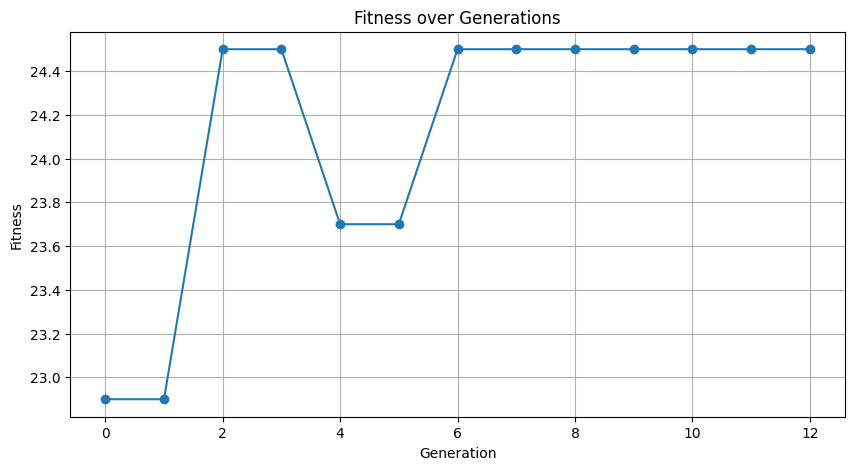

In [10]:
# Plot fitness over generations
plt.figure(figsize=(10, 5))
plt.plot(scheduler.fitness_history, marker='o')
plt.title('Fitness over Generations')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.grid(True)
plt.show()


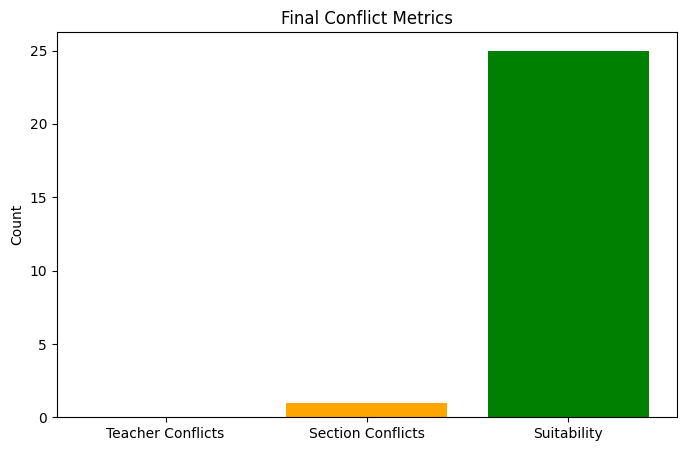

In [11]:
# Plot final metrics as bar chart
conflict_labels = ['Teacher Conflicts', 'Section Conflicts', 'Suitability']
conflict_values = [
    final_metrics['teacher_conflicts'],
    final_metrics['section_conflicts'],
    final_metrics['suitability']
]

plt.figure(figsize=(8, 5))
plt.bar(conflict_labels, conflict_values, color=['red', 'orange', 'green'])
plt.title('Final Conflict Metrics')
plt.ylabel('Count')
plt.show()


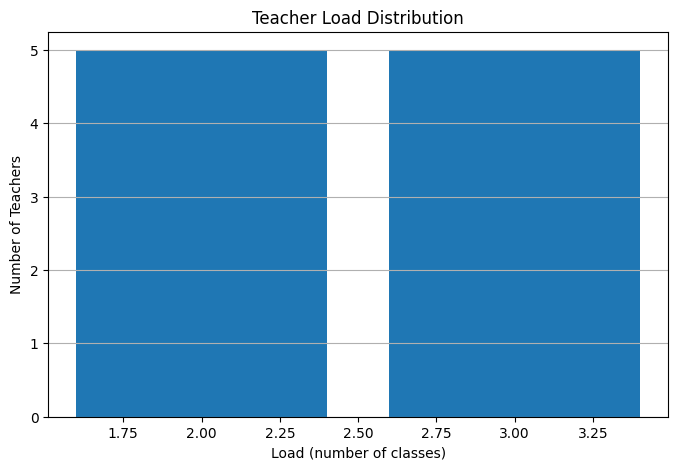

In [12]:
# Plot teacher load distribution
loads = list(final_metrics['teacher_loads'].values())
plt.figure(figsize=(8, 5))
plt.hist(loads, bins=range(min(loads), max(loads)+2), align='left', rwidth=0.8)
plt.title('Teacher Load Distribution')
plt.xlabel('Load (number of classes)')
plt.ylabel('Number of Teachers')
plt.grid(axis='y')
plt.show()
